In [1]:
from functools import partial
import pickle

from astropy.convolution import Gaussian2DKernel, convolve
from astropy.stats import median_absolute_deviation as MAD
import astropy.table as at
import astropy.units as u
import matplotlib as mpl
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np

from scipy.special import factorial, hermitenorm

import jax
jax.config.update('jax_enable_x64', True)
import jax.numpy as jnp
from jax_cosmo.scipy.interpolate import InterpolatedUnivariateSpline
import jaxopt

from schnecke.model import VerticalOrbitModel
from schnecke.data import get_data_im
from schnecke.jax_helpers import simpson

In [2]:
model = VerticalOrbitModel(
    dens_knots=jnp.linspace(0, np.sqrt(1.5), 8)**2,
    e_knots={
        2: jnp.array([0., 1.]),
        4: jnp.array([0., 1.]),
#         6: jnp.array([0., 1.]),
    }
)

No GPU/TPU found, falling back to CPU. (Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


In [3]:
Omegaz0 = ((15*u.km/u.s) / (450*u.pc)).to_value(1/u.Myr)

In [4]:
im_bins = {'z': np.linspace(-4, 4, 121)}
im_bins['vz'] = im_bins['z'] * Omegaz0

In [29]:
# test_data = at.QTable.read("test-data/GaiaDR3-zvz-Rg8.0-9.0.fits")
test_data = at.QTable.read("test-data/GaiaDR3-zvz-Rg9.5-10.5.fits")
# test_data = at.QTable.read("GaiaDR3-zvz-Rg10.0-11.0.fits")

# Simulated data to try here in test_data
# rng = np.random.default_rng(seed=42)
# test_data['z'] = rng.normal(
#     0, 1.5 * MAD(test_data['z'].value), size=len(test_data)
# ) * test_data['z'].unit
# test_data['vz'] = rng.normal(
#     0, 1.5 * MAD(test_data['vz'].value), size=len(test_data)
# ) * test_data['vz'].unit

data_H = get_data_im(test_data['z'], test_data['vz'], im_bins)
# data_H = get_data_im(test_data['z'][:len(test_data)//2], test_data['vz'][:len(test_data)//2], im_bins)

In [59]:
e_vals0 = {}
e_vals0[2] = jnp.array([0., 0.1])
e_vals0[4] = jnp.array([0., -0.05])
# e_vals0[6] = jnp.array([0., 0.02])

params0 = {
    'vz0': 0.,
    'z0': 0.,
    'ln_dens_vals': np.array([10.,  9.,  8., 6, 2] + [-5.] * (len(model.dens_knots) - 5)),
    'ln_Omega': np.log(Omegaz0 / 1.5),
    'e_vals': e_vals0,
}

bounds_l = {
    'vz0': -0.1,
    'z0': -0.5,
    'ln_dens_vals': np.full_like(params0['ln_dens_vals'], -5.),
    'ln_Omega': -5.,
    'e_vals': {
        2: np.full_like(params0['e_vals'][2], -0.3),
        4: np.full_like(params0['e_vals'][4], -0.3),
#         6: np.full_like(params0['e_vals'][6], -0.3),
    }
}

bounds_r = {
    'vz0': 0.1,
    'z0': 0.5,
    'ln_dens_vals': np.full_like(params0['ln_dens_vals'], 15.),
    'ln_Omega': 0.,
    'e_vals': {
        2: np.full_like(params0['e_vals'][2], 0.3),
        4: np.full_like(params0['e_vals'][4], 0.3),
#         6: np.full_like(params0['e_vals'][6], 0.3),
    }
}

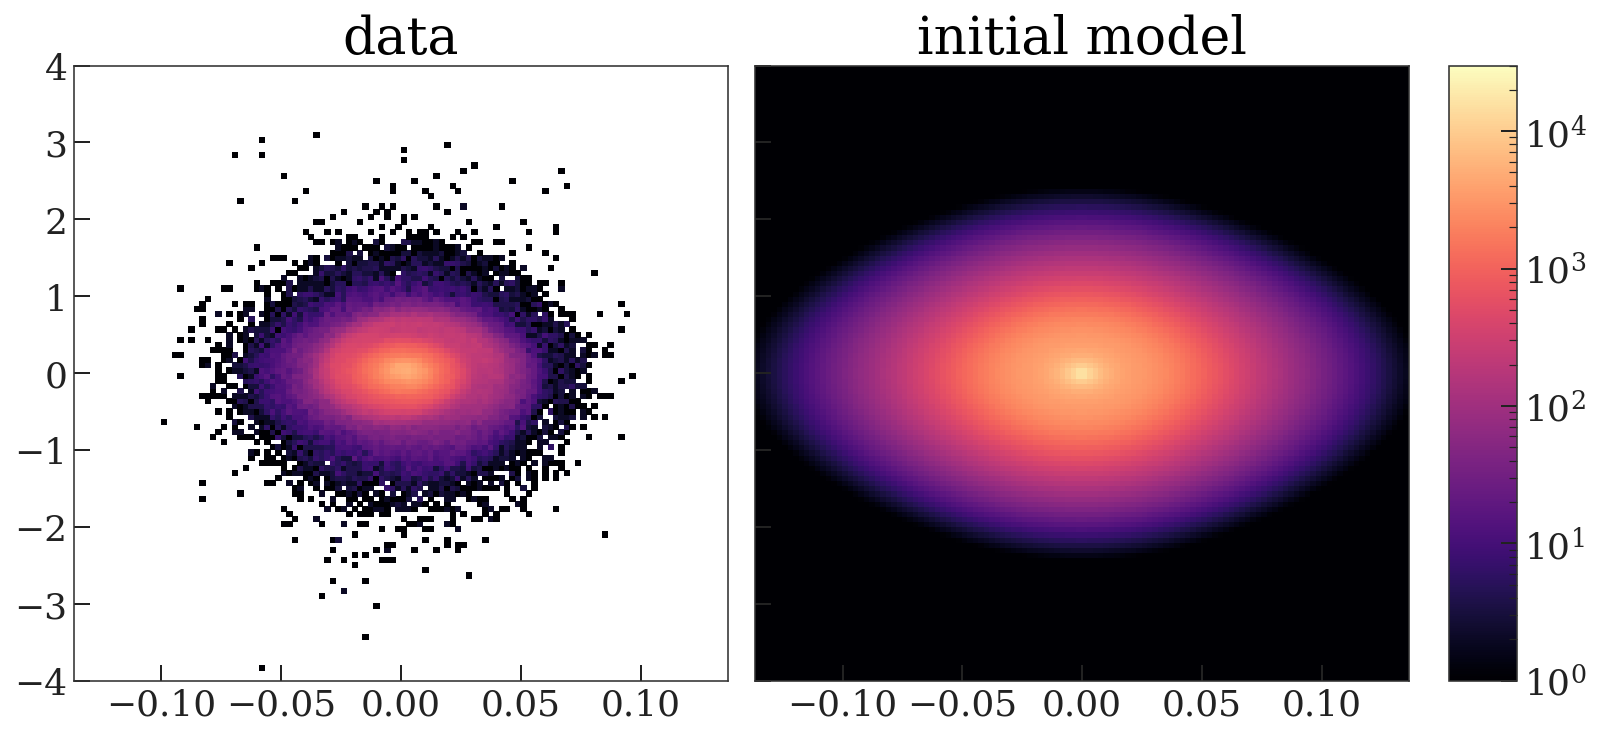

In [61]:
vlim = dict(norm=mpl.colors.LogNorm(vmax=3e4), shading='auto') # vmin=0, vmax=30)

fig, axes = plt.subplots(
    1, 2, figsize=(11, 5), sharex=True, sharey=True, 
    constrained_layout=True
)

cs = axes[0].pcolormesh(data_H['vz'], data_H['z'], data_H['H'], **vlim)

cs = axes[1].pcolormesh(
    data_H['vz'], data_H['z'], 
    np.exp(model.ln_density(params0, z=data_H['z'], vz=data_H['vz']).T), 
    **vlim
)
fig.colorbar(cs, ax=axes[:2])

axes[0].set_title('data')
axes[1].set_title('initial model');

In [62]:
_, init_rz, _ = model.get_rz_th(
    data_H['z'].ravel()[:10], data_H['vz'].ravel()[:10], 
    np.exp(params0['ln_Omega']), params0['e_vals']
)
de_de = jax.jacrev(model.get_es, argnums=[1])(
    init_rz, params0['e_vals'], 
)
for k, v in de_de.items():
    for v1 in v:
        for k2, v2 in v1.items():
            assert np.isfinite(v2[0]).all()

In [63]:
# jax.grad(model.objective)(bounds_r, **data_H)

In [64]:
res = model.optimize(
    params0, bounds=(bounds_l, bounds_r), **data_H, 
    jaxopt_kwargs=dict(options=dict(maxls=1000, disp=False))
)
res.state

ScipyMinimizeInfo(fun_val=Array(1.00281722, dtype=float64, weak_type=True), success=True, status=0, iter_num=857)

In [65]:
res.params

{'e_vals': {2: Array([-0.03597973,  0.3       ], dtype=float64),
  4: Array([ 0.00412003, -0.08199177], dtype=float64)},
 'ln_Omega': Array(-2.8843268, dtype=float64),
 'ln_dens_vals': Array([ 8.7938441 ,  8.03554857,  5.82108139,  1.73354327, -3.34756437,
        -5.        , -4.99990589, -4.99984829], dtype=float64),
 'vz0': Array(0.00152059, dtype=float64),
 'z0': Array(0.02508357, dtype=float64)}

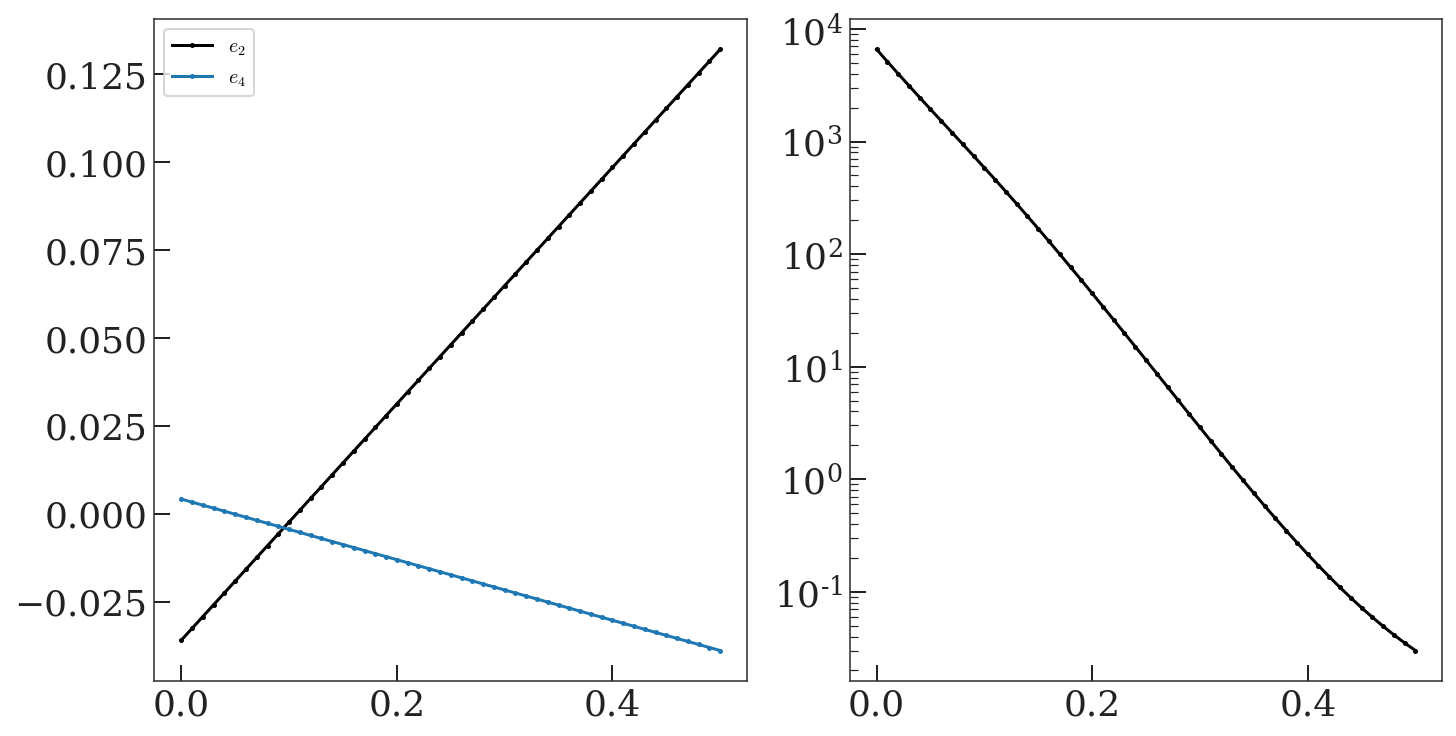

In [66]:
plot_rz = np.linspace(0, 0.5, 51)
es = model.get_es(plot_rz, res.params['e_vals'])
dens = np.exp(model.get_ln_dens(plot_rz, res.params['ln_dens_vals']))

fig, axes = plt.subplots(1, 2, figsize=(10, 5), constrained_layout=True)
for n in es:
    axes[0].plot(plot_rz, es[n], label=f'$e_{n}$')
axes[1].plot(plot_rz, dens)
axes[1].set_yscale('log')

axes[0].legend()

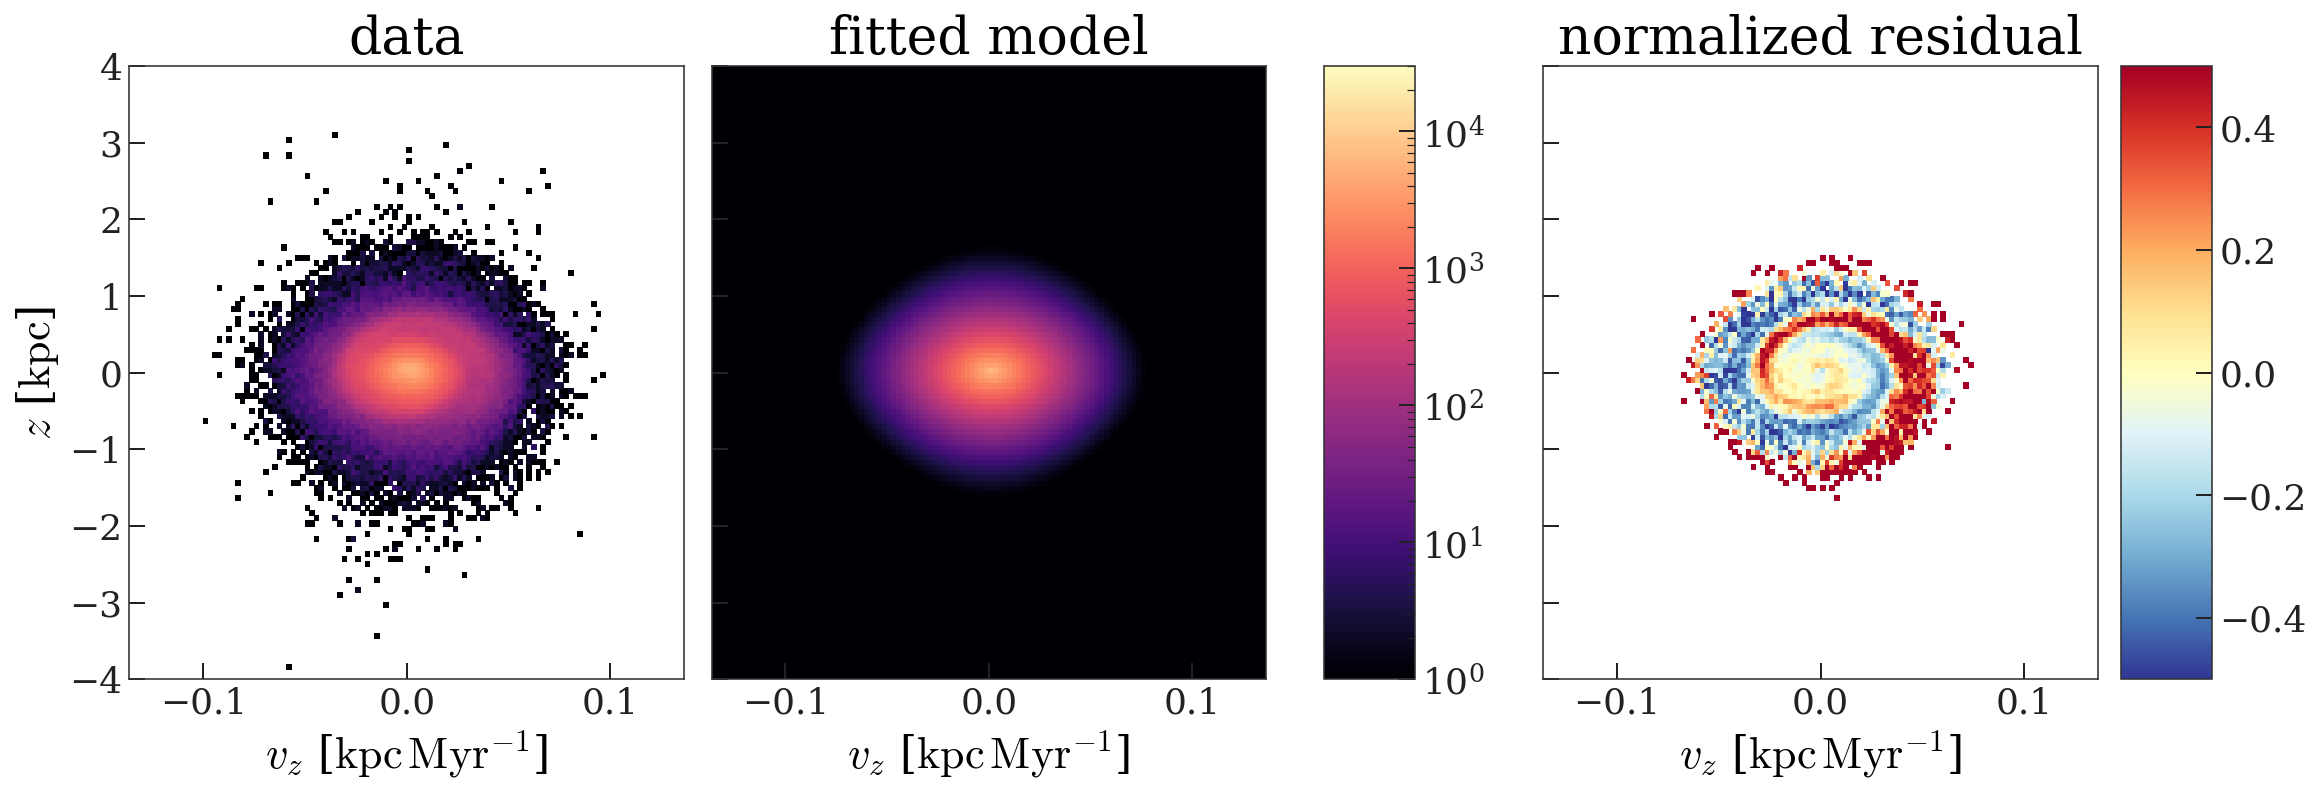

In [68]:
vlim = dict(norm=mpl.colors.LogNorm(vmax=3e4), shading='auto')

fig, axes = plt.subplots(
    1, 3, figsize=(16, 5.4), sharex=True, sharey=True, 
    constrained_layout=True
)

cs = axes[0].pcolormesh(data_H['vz'], data_H['z'], data_H['H'], **vlim)

model_H = np.exp(model.ln_density(res.params, z=data_H['z'], vz=data_H['vz']))

cs = axes[1].pcolormesh(data_H['vz'], data_H['z'], model_H, **vlim)
fig.colorbar(cs, ax=axes[:2])

resid = np.array((data_H['H'] - model_H) / model_H)
resid[data_H['H'] < 5] = np.nan
# resid = convolve(resid, Gaussian2DKernel(0.65))
cs = axes[2].pcolormesh(
    data_H['vz'], data_H['z'], 
    resid, 
    vmin=-0.5, vmax=0.5,
    cmap='RdYlBu_r',
    shading='auto'
)
fig.colorbar(cs, ax=axes[2])

for ax in axes:
    ax.set_xlabel(f'$v_z$ [{u.kpc/u.Myr:latex_inline}]')
axes[0].set_ylabel(f'$z$ [{u.kpc:latex_inline}]')

axes[0].set_title('data')
axes[1].set_title('fitted model')
axes[2].set_title('normalized residual');

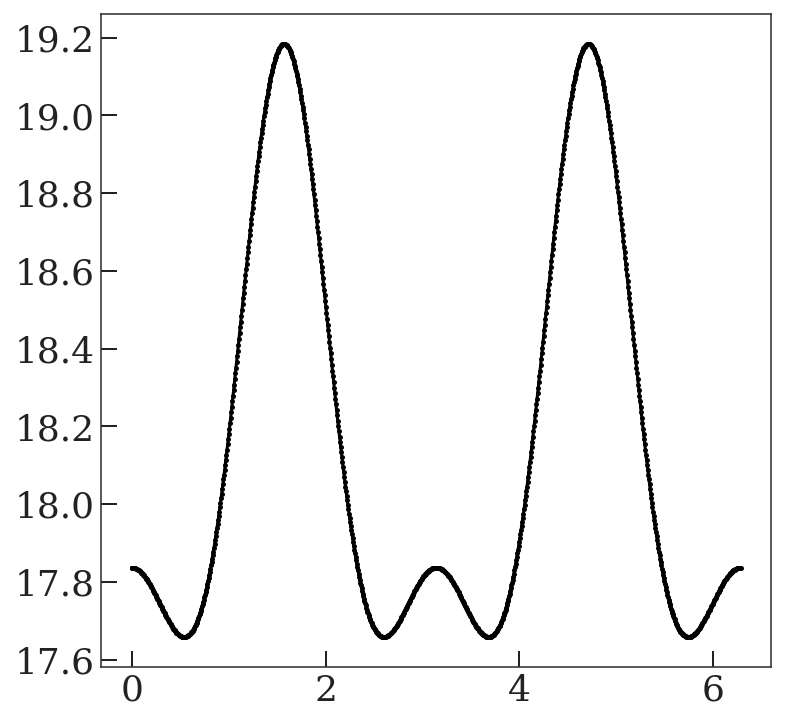

In [47]:
pars = {
    'e_vals': res.params['e_vals'], 
    'Omega': np.exp(res.params['ln_Omega'])
}
rzz = 0.1
th_ = np.linspace(0, 2*np.pi, 1024)
dz_dthp_func = jax.vmap(
    jax.grad(model.get_z, argnums=1),
    in_axes=[None, 0, None, None]
)
vz_th = model.get_vz(rzz, th_, res.params['e_vals'], np.exp(res.params['ln_Omega']))
dz_dthp = dz_dthp_func(rzz, th_, res.params['e_vals'], np.exp(res.params['ln_Omega']))
plt.plot(th_, dz_dthp / vz_th)

In [48]:
get_Tz_Jz_thz = jax.vmap(model.get_Tz_Jz_thz, in_axes=[0, 0, None, None])

In [49]:
get_Tz_Jz_thz(
    jnp.array([0.13, 0.15]), 
    jnp.array([0.005, -0.003]), 
    res.params['e_vals'], 
    np.exp(res.params['ln_Omega'])
)

(Array([106.92143957, 107.00235196], dtype=float64),
 Array([0.00070739, 0.00073551], dtype=float64),
 Array([0.99364028, 1.89706715], dtype=float64))

In [51]:
model_Tz, model_Jz, model_thz = get_Tz_Jz_thz(
    test_data['z'].to_value(u.kpc) - res.params['z0'], 
    test_data['vz'].to_value(u.kpc/u.Myr) - res.params['vz0'],
    res.params['e_vals'], 
    np.exp(res.params['ln_Omega'])
)

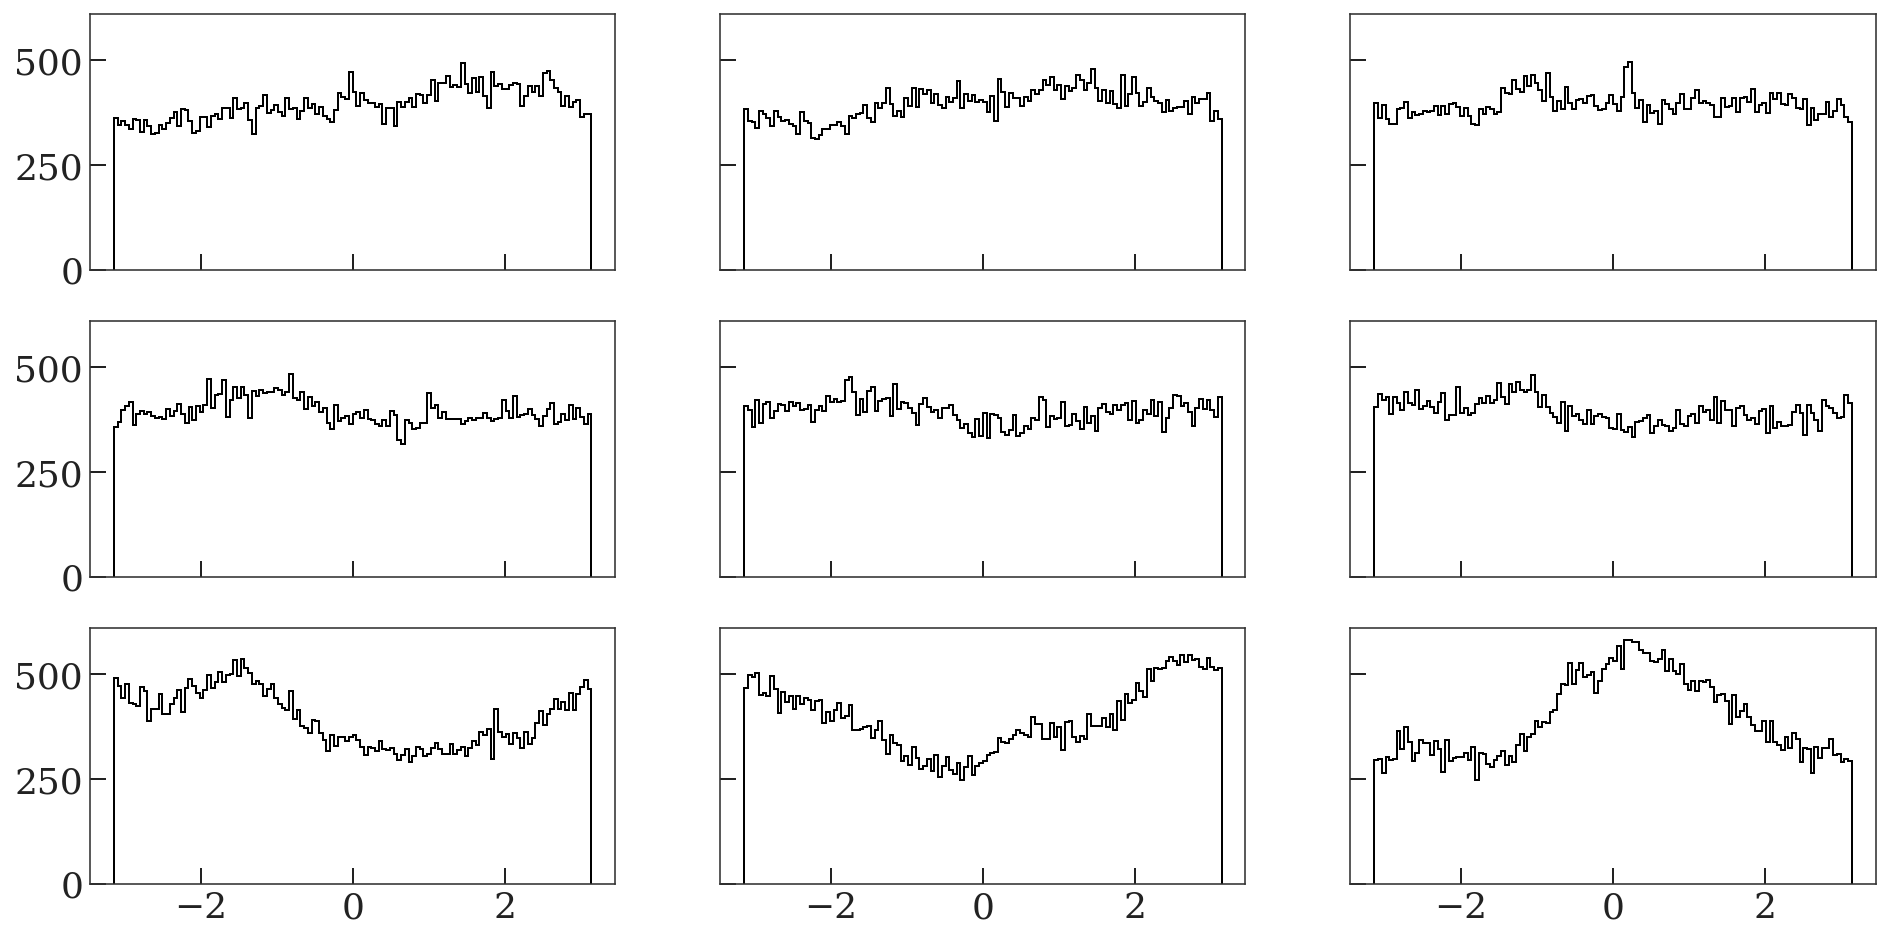

In [52]:
bins = np.nanpercentile(model_Jz, np.linspace(0, 100, 10))
fig, axes = plt.subplots(3, 3, figsize=(16, 8), sharex=True, sharey=True)
for ax, l, r in zip(axes.flat, bins[:-1], bins[1:]):
    mask_ = (model_Jz > l) & (model_Jz < r)
    ax.hist(np.array(model_thz)[mask_], bins=128, histtype='step');

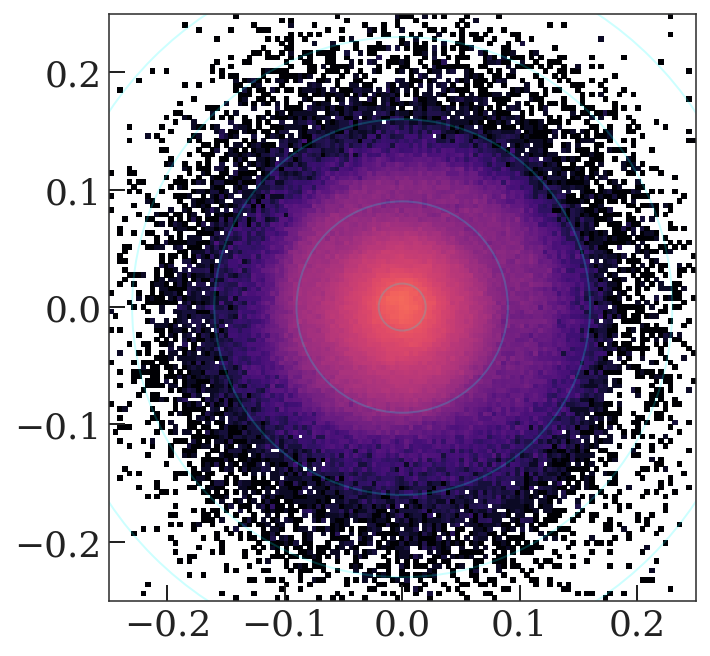

In [53]:
xx = np.sqrt(model_Jz) * np.cos(model_thz)
yy = np.sqrt(model_Jz) * np.sin(model_thz)

fig, ax = plt.subplots(1, 1, figsize=(5.4, 5.4))
cs = ax.hist2d(xx, yy, bins=np.linspace(-0.25, 0.25, 128), **vlim)
ax.set_aspect('equal')

for rr in np.linspace(0.02, 0.3, 5):
    circ = mpl.patches.Circle((0,0), rr, facecolor='none', edgecolor='cyan', alpha=0.2)
    ax.add_patch(circ)

(-6.283185307179586, 6.283185307179586)

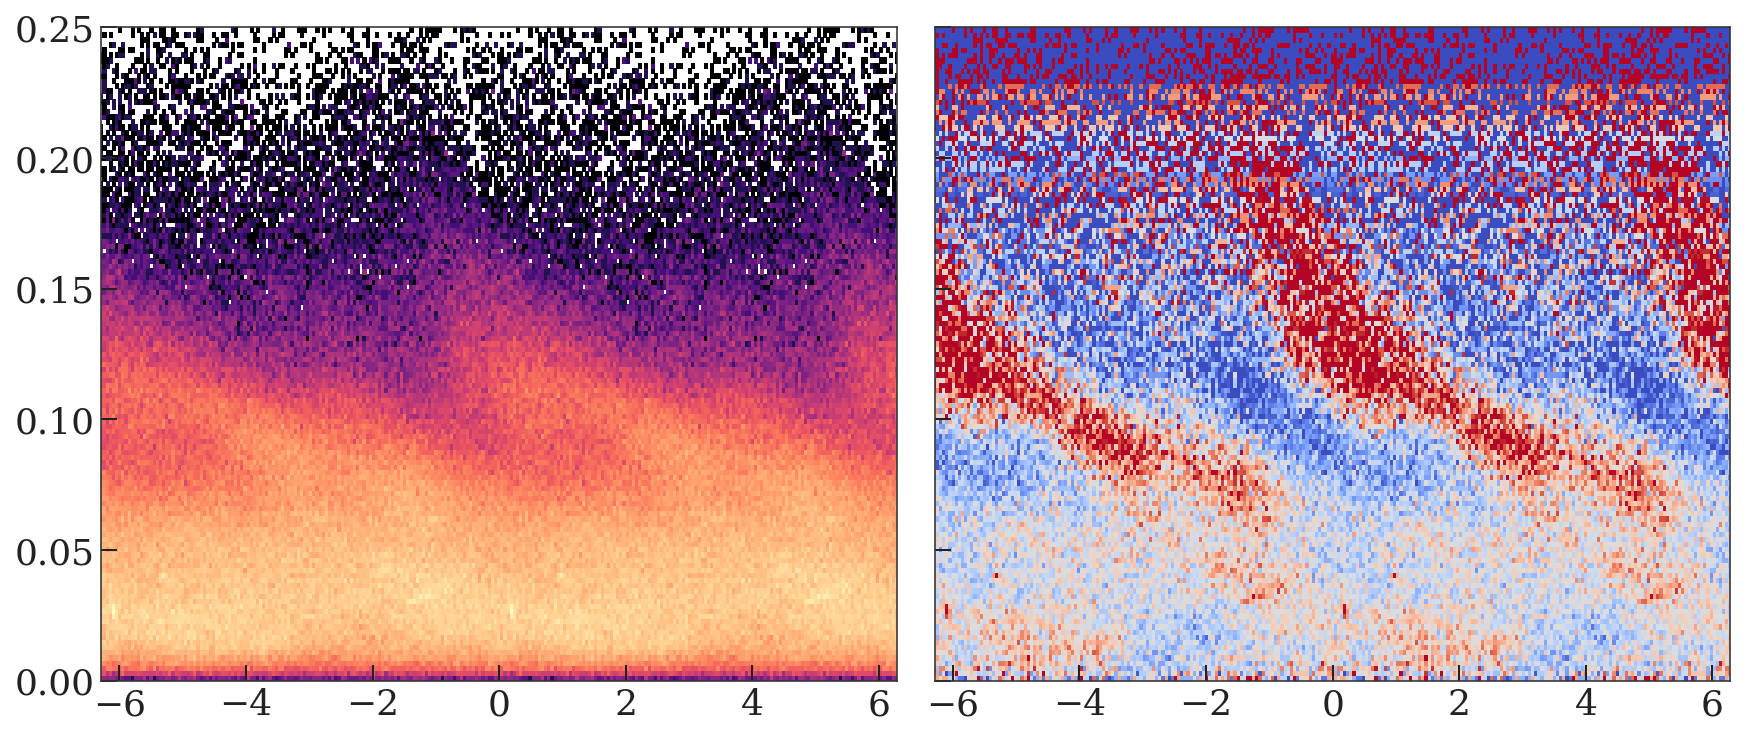

In [54]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, sharey=True,
    constrained_layout=True
)

for n in [-1, 0, 1]:
    H, xe, ye = np.histogram2d(
        model_thz + n * 2*np.pi, 
        np.sqrt(model_Jz), 
        bins=(np.linspace(-np.pi, np.pi, 128) + n * 2*np.pi, 
              np.linspace(0, 0.25, 128))
    )
    
    axes[0].pcolormesh(
        xe, ye, H.T,
        norm=mpl.colors.LogNorm()
    )
    
    model_H = np.nanmean(H.T, axis=1)[:, None]
    axes[1].pcolormesh(
        xe, ye, (H.T - model_H) / model_H,
        vmin=-0.5, vmax=0.5,
        cmap='coolwarm'
    )
    
axes[0].set_xlim(-2*np.pi, 2*np.pi)

In [56]:
model.get_rz_th(1., 0, np.exp(res.params['ln_Omega']), res.params['e_vals'])

(Array(0.22235116, dtype=float64),
 Array(0.23677675, dtype=float64),
 Array(1.57079633, dtype=float64))

In [118]:
def get_Tz_Jz(self, rz, e_vals, Omega, N_grid=1025):
    get_z = partial(model.get_z, rz=rz, e_vals=e_vals, Omega=Omega)
    dz_dthp_func = jax.vmap(
        jax.grad(model.get_z, argnums=1),
        in_axes=[None, 0, None, None]
    )
    
    # Grid of theta_prime to do the integral over:
    thp = np.linspace(0, np.pi / 2, N_grid)
    vz_th = self.get_vz(rz, thp, e_vals, Omega)
    dz_dthp = dz_dthp_func(rz, thp, e_vals, Omega)
    
    Tz = 4 * simpson(dz_dthp / vz_th, th_)
    Jz = 4 / (2*np.pi) * simpson(dz_dthp * vz_th, th_)
    
    return Tz, Jz

get_Tz_Jz = jax.jit(get_Tz_Jz, static_argnames=['self', 'N_grid'])
get_Tz_Jz(model, 0.1, res.params['e_vals'], np.exp(res.params['ln_Omega']))

(Array(97.0027312, dtype=float64), Array(0.00501146, dtype=float64))

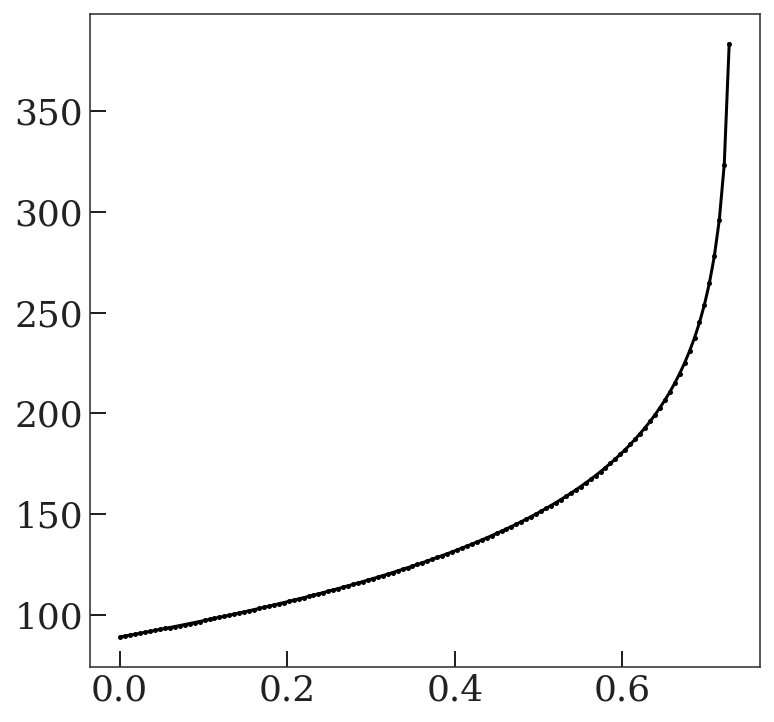

In [128]:
rzs = np.linspace(0, 0.75, 128) + 1e-3
Tzs = np.full_like(rzs, np.nan)
Jzs = np.full_like(rzs, np.nan)
for i, rz in enumerate(rzs):
    Tzs[i], Jzs[i] = get_Tz_Jz(
        model, rz, res.params['e_vals'], np.exp(res.params['ln_Omega'])
    )
    
plt.plot(rzs, Tzs)

In [21]:
rz, init_rz, init_th = model.get_rz_th(
    test_data['z'].to_value(u.kpc), 
    test_data['vz'].to_value(u.kpc/u.Myr), 
    np.exp(res.params['ln_Omega']), 
    res.params['e_vals'], 
)

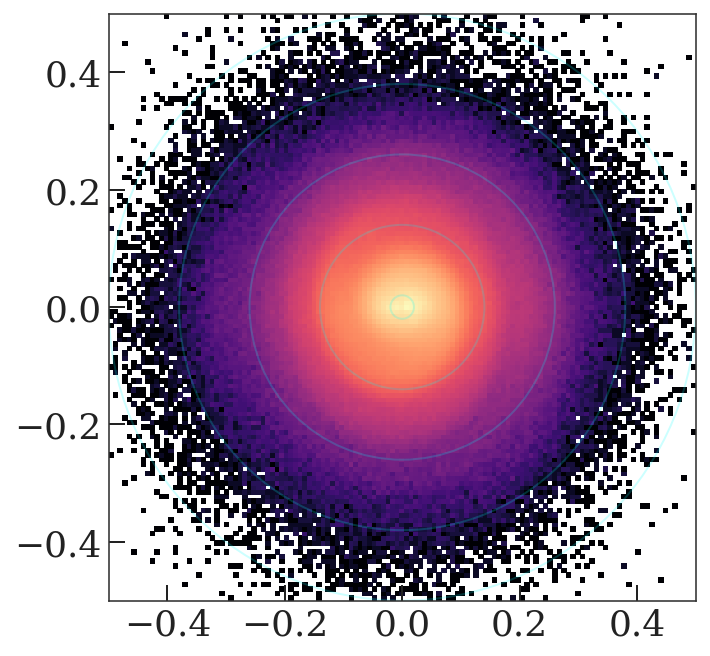

In [22]:
xx = rz * np.cos(init_th)
yy = rz * np.sin(init_th)

fig, ax = plt.subplots(1, 1, figsize=(5.4, 5.4))
cs = ax.hist2d(xx, yy, bins=np.linspace(-0.5, 0.5, 128), **vlim)
ax.set_aspect('equal')

for rr in np.linspace(0.02, 0.5, 5):
    circ = mpl.patches.Circle((0,0), rr, facecolor='none', edgecolor='cyan', alpha=0.2)
    ax.add_patch(circ)

(-6.283185307179586, 6.283185307179586)

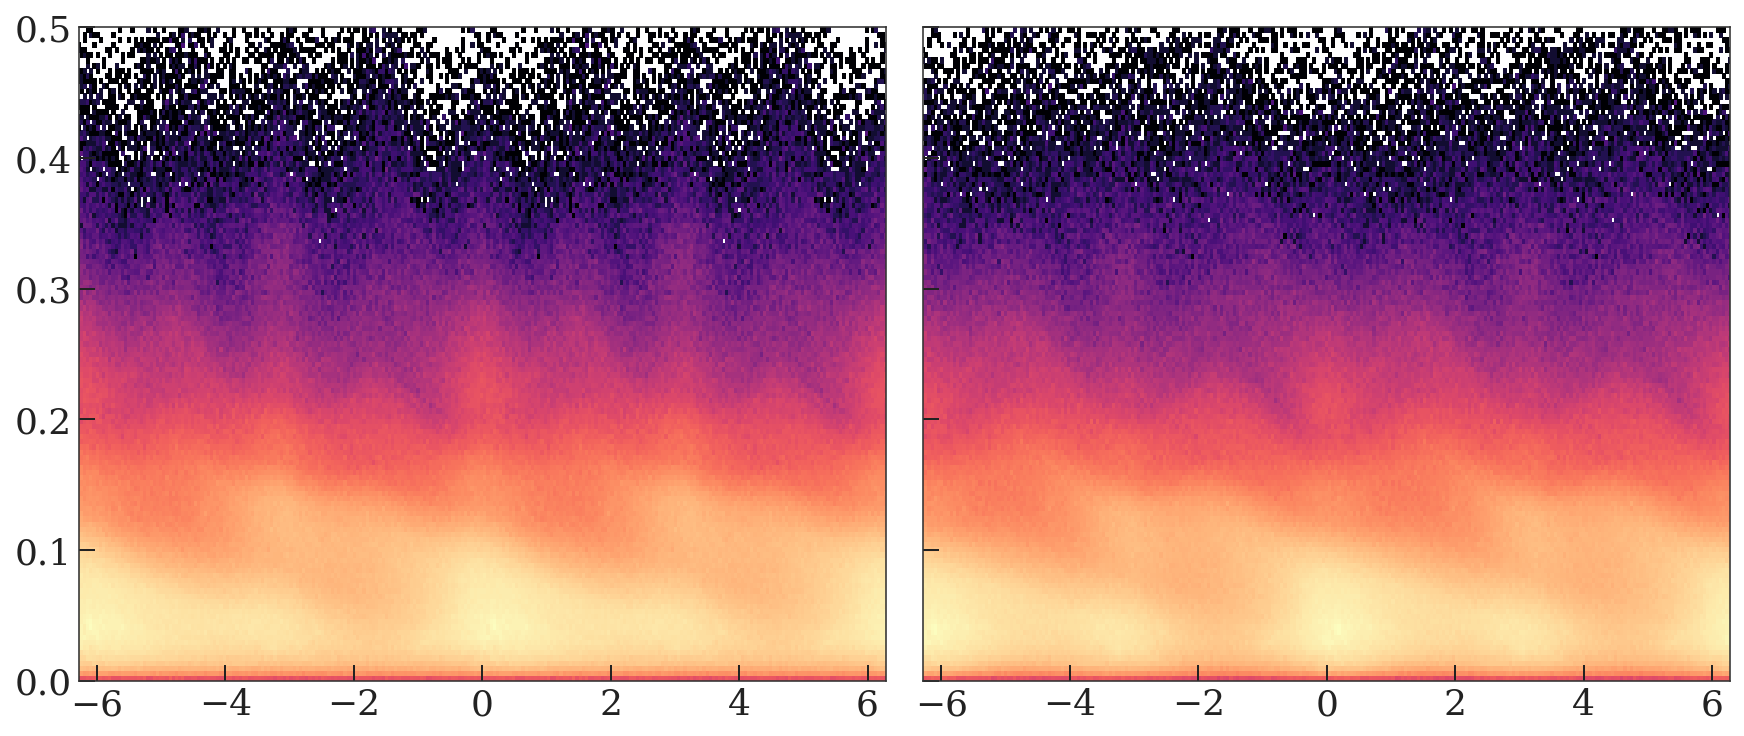

In [23]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, sharey=True,
    constrained_layout=True
)

for n in [-1, 0, 1]:
    axes[0].hist2d(
        init_th + n * 2*np.pi, 
        init_rz, 
        bins=(np.linspace(-np.pi, np.pi, 128) + n * 2*np.pi, 
              np.linspace(0, 0.5, 128)), 
        norm=mpl.colors.LogNorm()
    )
    
    axes[1].hist2d(
        init_th + n * 2*np.pi, 
        rz, 
        bins=(np.linspace(-np.pi, np.pi, 128) + n * 2*np.pi, 
              np.linspace(0, 0.5, 128)), 
        norm=mpl.colors.LogNorm()
    )
    
axes[0].set_xlim(-2*np.pi, 2*np.pi)

(-6.283185307179586, 6.283185307179586)

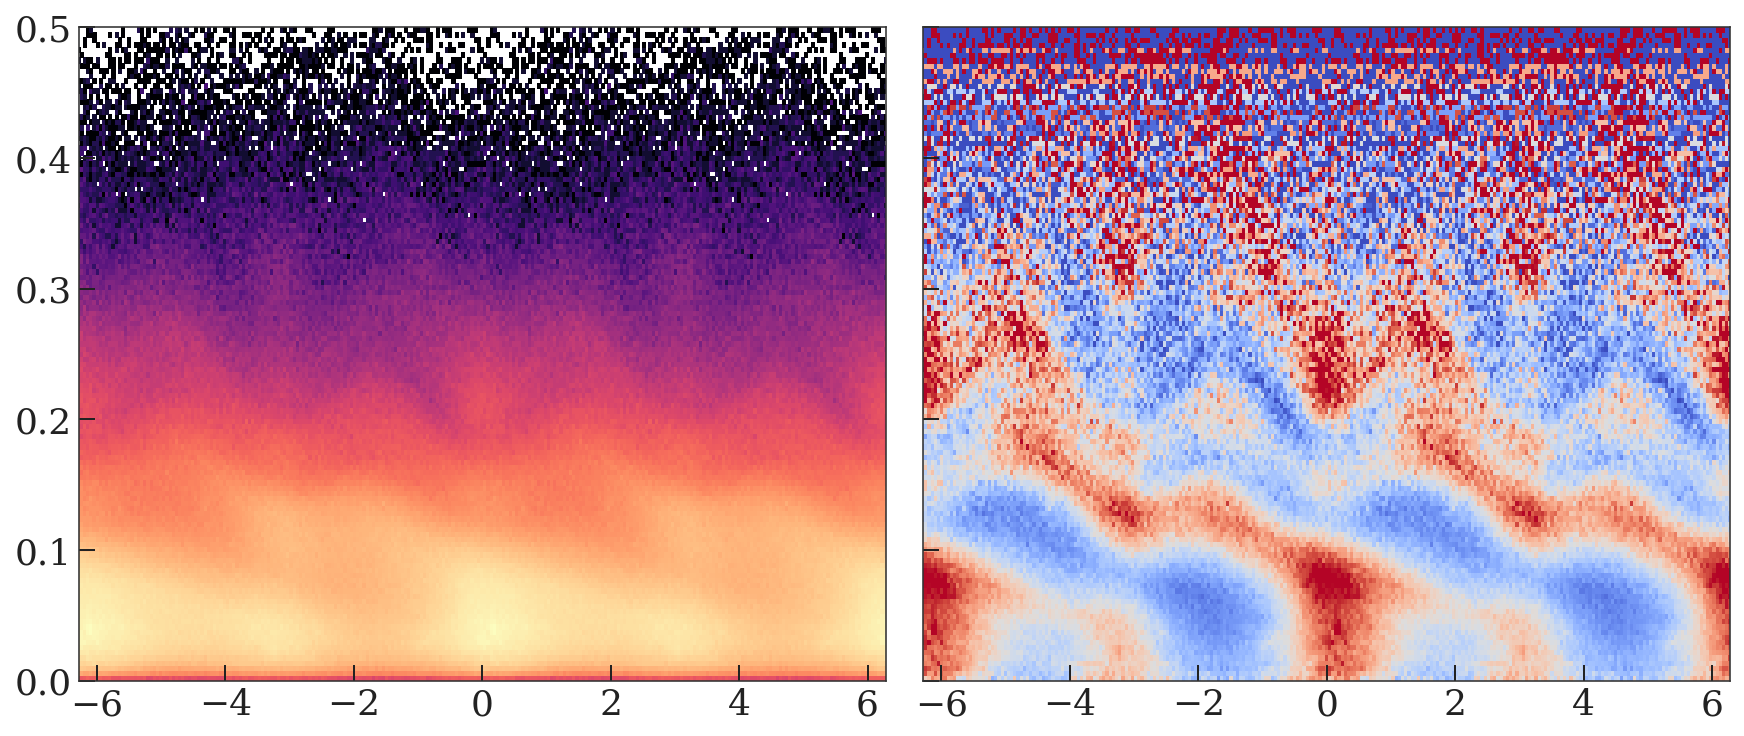

In [24]:
fig, axes = plt.subplots(
    1, 2, figsize=(12, 5), sharex=True, sharey=True,
    constrained_layout=True
)

for n in [-1, 0, 1]:
    H, xe, ye = np.histogram2d(
        init_th + n * 2*np.pi, 
        rz, 
        bins=(np.linspace(-np.pi, np.pi, 128) + n * 2*np.pi, 
              np.linspace(0, 0.5, 128))
    )
    
    axes[0].pcolormesh(
        xe, ye, H.T,
        norm=mpl.colors.LogNorm()
    )
    
#     rz_grid, th_grid = np.meshgrid(
#         0.5 * (ye[:-1] + ye[1:]), 
#         0.5 * (xe[:-1] + xe[1:])
#     )
#     zz = rz_grid * np.sin(th_grid) / np.exp(0.5 * res.params['ln_Omega'])
#     vzz = rz_grid * np.cos(th_grid) * np.exp(0.5 * res.params['ln_Omega'])
#     model_H = np.exp(model.ln_density(res.params, z=zz, vz=vzz))
    model_H = np.nanmean(H.T, axis=1)[:, None]
    axes[1].pcolormesh(
        xe, ye, (H.T - model_H) / model_H,
        vmin=-0.5, vmax=0.5,
        cmap='coolwarm'
    )
    
axes[0].set_xlim(-2*np.pi, 2*np.pi)

# Maths

---

# Matched filter

In [25]:
import optax
from jax.scipy.special import logsumexp, gammaln

@jax.jit
def mixture_ln_likelihood(params, z, vz, H, dH, model_kwargs):
    model = VerticalOrbitModel(**model_kwargs)

    dH_sign = jnp.sign(dH)
    
    # Expected number:
    ln_Lambda = logsumexp(
        jnp.array([model.ln_density(params, z, vz), params['log_alpha'] + jnp.log(jnp.abs(dH))]),
        b=jnp.array([jnp.ones_like(H), dH_sign]),
        axis=0
    )
    ln_Lambda = jnp.where(
        jnp.isfinite(ln_Lambda),
        ln_Lambda,
        -6.
    )
    # ln_Lambda = model.ln_density(params, z, vz)

    # gammaln(x+1) = log(factorial(x))
    return H * ln_Lambda - jnp.exp(ln_Lambda) - gammaln(H + 1)


@jax.jit
def mixture_objective(params, z, vz, H, dH, model_kwargs):
    return -mixture_ln_likelihood(params, z, vz, H, dH, model_kwargs).sum() / H.size


def get_perturbed_amplitude(data, params0, bounds, model_kwargs, rng):
    N = len(data)
    idx = rng.choice(N, size=N, replace=False)

    A_idx = idx[:N//2]
    B_idx = idx[N//2:]
    data_A = get_data_im(data['z'][A_idx], data['vz'][A_idx], bins=im_bins)
    data_B = get_data_im(data['z'][B_idx], data['vz'][B_idx], bins=im_bins)

    model = VerticalOrbitModel(**model_kwargs)
    res_A = model.optimize(params0, bounds=bounds, **data_A)
    print('A state', res_A.state)
    
    model_A = np.exp(model.ln_density(res_A.params, z=data_A['z'], vz=data_A['vz']))
    dH_A = data_A['H'] - model_A
    
    mixture_params0 = res_A.params.copy()
    mixture_params0['log_alpha'] = -2.
    
    mixture_bounds = [bounds[0].copy(), bounds[1].copy()]
    mixture_bounds[0]['log_alpha'] = -10
    mixture_bounds[1]['log_alpha'] = 1.
    
    # optimizer = jaxopt.ScipyBoundedMinimize(
    #     fun=mixture_objective, 
    #     method='L-BFGS-B', 
    #     maxiter=16384,
    # )
    
    opt = optax.adam(1e-2)
    optimizer = jaxopt.OptaxSolver(opt=opt, fun=mixture_objective, maxiter=10000)
    
    mixture_res_B = optimizer.run(
        init_params=mixture_params0, **data_B, dH=dH_A, 
        model_kwargs=model_kwargs, 
        # bounds=mixture_bounds
    )
    print('B state', mixture_res_B.state)
    
    return mixture_res_B.params

In [26]:
model_kw = dict(dens_knots=model.dens_knots, e_knots=model.e_knots,)
rng = np.random.default_rng(seed=42)

log_alphas = []
for i in range(4):
    params = get_perturbed_amplitude(
        test_data, res.params, bounds=(bounds_l, bounds_r), 
        model_kwargs=model_kw, rng=rng
    )
    log_alphas.append(params['log_alpha'])

A state ScipyMinimizeInfo(fun_val=Array(3.03187156, dtype=float64, weak_type=True), success=True, status=0, iter_num=589)
B state OptaxState(iter_num=Array(1741, dtype=int64, weak_type=True), value=Array(1.19123301, dtype=float64), error=Array(0.00099978, dtype=float64), internal_state=(ScaleByAdamState(count=Array(1741, dtype=int32), mu={'e_vals': {2: Array([-6.94670632e-04, -4.29627715e-05], dtype=float64), 4: Array([-6.81358409e-06, -2.09841706e-06], dtype=float64)}, 'ln_Omega': Array(-0.00072857, dtype=float64), 'ln_dens_vals': Array([ 1.08890191e-07, -4.39820384e-06, -1.61017747e-05,  5.67809034e-06,
        3.76271933e-06,  1.82730157e-06,  3.96865752e-07, -1.81774898e-07],      dtype=float64), 'log_alpha': Array(4.62019183e-07, dtype=float64, weak_type=True), 'vz0': Array(3.68358765e-07, dtype=float64), 'z0': Array(5.40945198e-10, dtype=float64)}, nu={'e_vals': {2: Array([0.87682048, 0.0110485 ], dtype=float64), 4: Array([0.09418469, 0.00121879], dtype=float64)}, 'ln_Omega': Arr

In [27]:
log_alphas

[Array(-0.08207714, dtype=float64),
 Array(-0.0753468, dtype=float64),
 Array(-0.08379137, dtype=float64),
 Array(-0.07443711, dtype=float64)]

In [151]:
log_alphas

[Array(-0.08910608, dtype=float64),
 Array(-0.08030768, dtype=float64),
 Array(-0.09028631, dtype=float64),
 Array(-0.07729901, dtype=float64)]

In [193]:
mixture_params0 = res.params.copy()
# mixture_params0['log_alpha'] = -0.08
mixture_params0['log_alpha'] = -1.

In [194]:
model.ln_poisson_likelihood(res.params, **data_B)

Array(-707325.45812984, dtype=float64)

In [195]:
# mixture_ln_likelihood(mixture_params0, **data_B, dH=dH_A, model=model)
mixture_objective(mixture_params0, **data_B, dH=dH_A)

Array(49.12129888, dtype=float64)

In [196]:
optimizer = jaxopt.ScipyMinimize(
    fun=mixture_objective, 
    method='L-BFGS-B', 
    maxiter=16384,
)
mixture_res_B = optimizer.run(init_params=mixture_params0, **data_B, dH=dH_A)
mixture_res_B.state

ScipyMinimizeInfo(fun_val=Array(0.35467975, dtype=float64, weak_type=True), success=True, status=0, iter_num=182)

In [197]:
mixture_res_B.params['log_alpha']

Array(-13.27880427, dtype=float64)